## 🏈 NFL Big Data Bowl 2024 - Proof of Concept

### Overview  
This notebook is a **proof of concept** for predicting tackles in NFL games using **Week 1 tracking data** from the NFL Big Data Bowl 2024. The goal is to build a **baseline model** and validate the **data pipeline** before expanding to more advanced feature engineering and modeling.

### Target Variable  
The target variable (`tackle_label`) is defined as **1 if a player made a tackle** and **0 otherwise**. This is determined by merging the tracking data with the official **tackles dataset**.

### Approach  
- **Use only Week 1 data** to test the pipeline.  
- **Extract and merge tackler and ball carrier positions**.  
- **Train a simple XGBoost model** using relevant movement-based features.  
- **Evaluate model performance** using **F1-score and confusion matrix**.

### Next Steps  
- Expand feature engineering.  
- Tune hyperparameters and experiment with different models.  
- Scale to multiple weeks for improved generalization.  


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import os

In [99]:
print("Loading data...")
data_folder = "../data"
contents = os.listdir(data_folder)
print(contents)
# Update file paths to use data_folder
games_path = os.path.join(data_folder, 'games.csv')
plays_path = os.path.join(data_folder, 'plays.csv')
players_path = os.path.join(data_folder, 'players.csv')
week1_path = os.path.join(data_folder, 'tracking_week_1.csv')
tackles_path = os.path.join(data_folder, 'tackles.csv')

# Load the data
df_games = pd.read_csv(games_path)
df_plays = pd.read_csv(plays_path)
df_players = pd.read_csv(players_path)
# players = players.drop("displayName", axis=1)
df_tracking = pd.read_csv(week1_path)
df_tackles = pd.read_csv(tackles_path)

# # Ball tracking data should be added as additional information for each frame. 
# ball_tracking = tracking[tracking['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
# ball_tracking = ball_tracking.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
# tracking = tracking[tracking['displayName'] != 'football']
# tracking = tracking.merge(ball_tracking, on=['gameId', 'playId', 'frameId'], how='left')

print("Plays:", df_plays.shape, "Tackles:", df_tackles.shape, "Tracking:", df_tracking.shape)

Loading data...
['.~lock.full_data.csv#', 'full_data.csv', 'games.csv', 'players.csv', 'plays.csv', 'README.md', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']
Plays: (12486, 35) Tackles: (17426, 7) Tracking: (1407439, 17)


In [100]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180
    
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])       
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])       
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [101]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))
df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [49]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )
    df_tracking_plays_final['event']=np.where(df_tracking_plays_final['tackle']==1, 'tackle', np.where(df_tracking_plays_final['pff_missedTackle']==1, 'missed_tackle', (np.where(df_tracking_plays_final['assist']==1, 'assist', 'Other')) ))
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], how='inner', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[( (df_tackles_final['tackle']+df_tackles_final['assist']+df_tackles_final['pff_missedTackle']>=1)&(df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [ ]:
print("df_tackles_final:", df_tackles_final.shape)
df_tackles_final.columns.values


df_tackles_final: (93001, 63)


array(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'gameplayid', 'index_x', 'ballCarrierId',
       'ballCarrierDisplayName', 'playDescription', 'quarter', 'down',
       'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints',
       'expectedPointsAdded', 'foulName1', 'foulName2', 'foulNFLId1',
       'foulNFLId2', 'tackle', 'assist', 

In [55]:
df_tracking.shape

(1407439, 23)

In [69]:
df_ballcarrier_players=df_players.copy()
df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
df_ballcarrier_players
   

,nflId_ballcarrier,ballCarrierHeight,ballCarrierWeight,ballcarrierDOB,ballcarrierCollege,ballcarrierPosition,ballCarrierDisplayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan
...,...,...,...,...,...,...,...
1678,55200,6-6,266,NaN,Indiana,DT,Ryder Anderson
1679,55212,6-0,230,NaN,Iowa State,ILB,Jake Hummel
1680,55239,6-2,300,NaN,Pennsylvania,DT,Prince Emili
1681,55240,6-1,185,NaN,Buffalo,CB,Ja'Marcus Ingram


In [80]:
df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
df_tracking_ballcarrier

,gameplayid,frameId,nflId,x,y,s,a,dis,o,dir,event,o_standard,dir_standard,x_standard,y_standard
0,202209080056,1,35472.0,88.370000,27.27,1.62,1.15,0.16,231.74,147.90,NaN,51.74,327.90,31.630000,26.063333
1,202209080056,2,35472.0,88.470000,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,50.98,328.53,31.530000,26.203333
2,202209080056,3,35472.0,88.560000,27.01,1.57,0.49,0.15,230.98,147.05,NaN,50.98,327.05,31.440000,26.323333
3,202209080056,4,35472.0,88.640000,26.90,1.44,0.89,0.14,232.38,145.42,NaN,52.38,325.42,31.360000,26.433333
4,202209080056,5,35472.0,88.720000,26.80,1.29,1.24,0.13,233.36,141.95,NaN,53.36,321.95,31.280000,26.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,20220912003826,49,NaN,56.220001,9.89,2.56,1.25,0.25,NaN,NaN,tackle,NaN,NaN,63.779999,43.443333
1407435,20220912003826,50,NaN,56.060001,10.08,2.50,1.14,0.24,NaN,NaN,NaN,NaN,NaN,63.939999,43.253333
1407436,20220912003826,51,NaN,55.889999,10.27,2.38,1.70,0.25,NaN,NaN,NaN,NaN,NaN,64.110001,43.063333
1407437,20220912003826,52,NaN,55.730000,10.44,2.07,2.83,0.24,NaN,NaN,NaN,NaN,NaN,64.270000,42.893334


In [81]:
df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
df_ballcarrier

,gameplayid,frameId,nflId,x,y,s,a,dis,o,dir,...,dir_standard,x_standard,y_standard,nflId_ballcarrier,ballCarrierHeight,ballCarrierWeight,ballcarrierDOB,ballcarrierCollege,ballcarrierPosition,ballCarrierDisplayName
0,202209080056,1,35472.0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,...,327.90,31.63,26.063333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
1,202209080056,2,35472.0,88.47,27.13,1.67,0.61,0.17,230.98,148.53,...,328.53,31.53,26.203333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
2,202209080056,3,35472.0,88.56,27.01,1.57,0.49,0.15,230.98,147.05,...,327.05,31.44,26.323333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
3,202209080056,4,35472.0,88.64,26.90,1.44,0.89,0.14,232.38,145.42,...,325.42,31.36,26.433333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
4,202209080056,5,35472.0,88.72,26.80,1.29,1.24,0.13,233.36,141.95,...,321.95,31.28,26.533333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346241,20220912003826,49,54618.0,50.75,6.92,1.88,2.49,0.19,33.48,64.07,...,244.07,69.25,46.413333,54618,6-4,205,NaN,Texas-San Antonio,CB,Tariq Woolen
1346242,20220912003826,50,54618.0,50.91,7.01,1.84,2.35,0.18,32.09,55.26,...,235.26,69.09,46.323333,54618,6-4,205,NaN,Texas-San Antonio,CB,Tariq Woolen
1346243,20220912003826,51,54618.0,51.06,7.13,1.85,1.98,0.18,32.09,49.15,...,229.15,68.94,46.203333,54618,6-4,205,NaN,Texas-San Antonio,CB,Tariq Woolen
1346244,20220912003826,52,54618.0,51.19,7.26,1.85,1.69,0.19,32.09,43.43,...,223.43,68.81,46.073333,54618,6-4,205,NaN,Texas-San Antonio,CB,Tariq Woolen


In [82]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)
df_ballcarrier.head()

,gameplayid,frameId,x_ballcarrier,y_ballcarrier,s_ballcarrier,a_ballcarrier,dis_ballcarrier,o_ballcarrier,dir_ball_carrier,event_ballcarrier,...,dir_standard_ballcarrier,x_standard_ballcarrier,y_standard_ballcarrier,nflId_ballcarrier,ballCarrierHeight,ballCarrierWeight,ballcarrierDOB,ballcarrierCollege,ballcarrierPosition,ballCarrierDisplayName
0,202209080056,1,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,...,327.90,31.63,26.063333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
1,202209080056,2,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,...,328.53,31.53,26.203333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
2,202209080056,3,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,...,327.05,31.44,26.323333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
3,202209080056,4,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,...,325.42,31.36,26.433333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold
4,202209080056,5,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,...,321.95,31.28,26.533333,35472,6-5,325,1988-06-06,Indiana,G,Rodger Saffold


In [64]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={'nflId':'nflId_tackler', 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)

In [96]:
print("df_full:", df_full.shape)
df_full.columns.values


df_full: (93001, 88)


array(['gameId', 'playId', 'nflId_tackler', 'displayName', 'frameId',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x_tackler',
       'y_tackler', 's_tackler', 'a_tackler', 'dis_tackler', 'o_tackler',
       'dir_tackler', 'event_tackler', 'o_standard_tackler',
       'dir_standard_tackler', 'x_standard_tackler', 'y_standard_tackler',
       'gameplayid', 'index_x', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPo

In [98]:
df_full.to_csv('../data/full_data.csv', index=False)

In [108]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName']).agg({'time':['min', 'max'], 'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean', 'std', 'skew'], 'y_tackler':['min', 'max','mean', 'std', 'skew'],
                                  's_tackler':['min', 'max','mean', 'std', 'skew'], 'a_tackler':['min', 'max','mean', 'std', 'skew'], 'dis_tackler':['min', 'max','mean', 'std', 'skew'],
                                  'o_tackler':['min', 'max','mean', 'std', 'skew'], 'dir_tackler':['min', 'max','mean', 'std', 'skew'], 'o_standard_tackler':['min', 'max','mean', 'std', 'skew'],
                                  'dir_standard_tackler':['min', 'max','mean', 'std', 'skew'], 'x_standard_tackler':['min', 'max','mean', 'std', 'skew'], 'y_standard_tackler':['min', 'max','mean', 'std', 'skew'],
                                  'quarter':['min', 'max','mean', 'std', 'skew'], 'down':['min', 'max','mean', 'std', 'skew'], 'yardsToGo':['min', 'max','mean', 'std', 'skew'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean', 'std', 'skew'], 'preSnapVisitorScore':['min', 'max','mean', 'std', 'skew'],
                                  'passLength':['min', 'max','mean', 'std', 'skew'], 'absoluteYardlineNumber':['min', 'max','mean', 'std', 'skew'], 'defendersInTheBox': ['min', 'max','mean', 'std', 'skew'],
                                  'expectedPoints':['min', 'max','mean', 'std', 'skew'], 'tackle':'max', 'assist':'max',  'pff_missedTackle':'max', 'tacklerWeight': 'mean',
                                  'x_ballcarrier': ['min', 'max','mean', 'std', 'skew'], 'y_ballcarrier':['min', 'max','mean', 'std', 'skew'], 's_ballcarrier':['min', 'max','mean', 'std', 'skew'],
                                  'a_ballcarrier':['min', 'max','mean', 'std', 'skew'], 'dis_ballcarrier': ['min', 'max','mean', 'std', 'skew'], 'o_ballcarrier':['min', 'max','mean', 'std', 'skew'],
                                  'o_standard_ballcarrier':['min', 'max','mean', 'std', 'skew'],'dir_standard_ballcarrier':['min', 'max','mean', 'std', 'skew'],
                                  'x_standard_ballcarrier':['min', 'max','mean', 'std', 'skew'], 'y_standard_ballcarrier':['min', 'max','mean', 'std', 'skew'], 'ballCarrierWeight':'mean',
                                 }).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)


In [110]:
df_full_grouped.to_csv('../data/full_data_grouped.csv', index=False)

In [117]:
df_full_grouped['tackle|max'].value_counts()

tackle|max
1    1214
0     837
Name: count, dtype: int64

In [129]:
#create final target variable
df_full_grouped['tackle_success']=np.where(((df_full_grouped['tackle|max']==1)), 1, 0)
df_final = df_full_grouped[df_full_grouped.columns]


In [130]:
# df_final_subset=df_final.select_dtypes(include=[np.number])

In [131]:
print(len(df_final))
print(df_final.tackle_success.sum())
print(df_final['pff_missedTackle|max'].sum())

2051
1214
256


In [132]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_final=create_position_variables(df_final)

In [133]:
df_final

,gameplayid,displayName,time|min,time|max,offenseFormation|first,tacklerPosition|mode,ballcarrierPosition|mode,x_tackler|min,x_tackler|max,x_tackler|mean,...,tacklerPosition|mode_MLB,tacklerPosition|mode_NT,tacklerPosition|mode_OLB,tacklerPosition|mode_SS,offenseFormation|first_I_FORM,offenseFormation|first_JUMBO,offenseFormation|first_PISTOL,offenseFormation|first_SHOTGUN,offenseFormation|first_SINGLEBACK,offenseFormation|first_WILDCAT
0,2022090800101,Troy Hill,2022-09-08 20:25:08.200000,2022-09-08 20:25:13.000000,I_FORM,CB,RB,64.58,69.59,66.814898,...,False,False,False,False,True,False,False,False,False,False
1,20220908001030,David Long,2022-09-08 21:01:44.799999,2022-09-08 21:01:46.700000,SHOTGUN,CB,WR,58.42,62.51,60.197000,...,False,False,False,False,False,False,False,True,False,False
2,20220908001102,Terrell Lewis,2022-09-08 21:03:51.299999,2022-09-08 21:03:56.200000,SHOTGUN,OLB,RB,84.39,88.01,85.324000,...,False,False,True,False,False,False,False,True,False,False
3,20220908001102,Troy Hill,2022-09-08 21:03:51.299999,2022-09-08 21:03:56.200000,SHOTGUN,CB,RB,84.89,91.48,86.938200,...,False,False,False,False,False,False,False,True,False,False
4,20220908001187,DaQuan Jones,2022-09-08 21:08:54.200000,2022-09-08 21:08:59.599999,SINGLEBACK,DT,RB,66.02,69.97,68.721091,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2022091200810,Jordyn Brooks,2022-09-12 20:47:16.599999,2022-09-12 20:47:22.200000,SINGLEBACK,ILB,RB,63.16,68.00,66.348772,...,False,False,False,False,False,False,False,False,True,False
2047,2022091200810,Quandre Diggs,2022-09-12 20:47:16.599999,2022-09-12 20:47:22.200000,SINGLEBACK,FS,RB,55.28,63.79,59.024561,...,False,False,False,False,False,False,False,False,True,False
2048,2022091200910,Cody Barton,2022-09-12 20:52:23.700000,2022-09-12 20:52:28.400000,SINGLEBACK,MLB,RB,52.63,54.97,53.815625,...,True,False,False,False,False,False,False,False,True,False
2049,2022091200910,Jordyn Brooks,2022-09-12 20:52:23.700000,2022-09-12 20:52:28.400000,SINGLEBACK,ILB,RB,52.04,55.78,54.050000,...,False,False,False,False,False,False,False,False,True,False


In [134]:
df_final_subset=df_final.select_dtypes(include=[np.number])
df_final_subset[[ 'QB_ballcarrier',
       'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier',
       'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS', 'offenseFormation|first_I_FORM',
       'offenseFormation|first_JUMBO', 'offenseFormation|first_PISTOL',
       'offenseFormation|first_SHOTGUN',
       'offenseFormation|first_SINGLEBACK',
       'offenseFormation|first_WILDCAT']]=df_final[[ 'QB_ballcarrier',
       'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier',
       'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS', 'offenseFormation|first_I_FORM',
       'offenseFormation|first_JUMBO', 'offenseFormation|first_PISTOL',
       'offenseFormation|first_SHOTGUN',
       'offenseFormation|first_SINGLEBACK',
       'offenseFormation|first_WILDCAT']]

In [140]:
X=df_final[[
      'dir_standard_tackler|min',
       'dir_standard_tackler|max', 'dir_standard_tackler|std',
       's_ballcarrier|max',  'a_ballcarrier|min',
       'o_standard_ballcarrier|mean',
       'dir_standard_ballcarrier|min',  
       'dis_tackler|min', 's_tackler|min', 'o_standard_tackler|min',
       'a_tackler|min', 
       'dis_tackler|mean']]
X.fillna(0, inplace=True) ##fill in missing pass length to 0

Y=df_final['tackle_success']

C:\Users\damja\AppData\Local\Temp\ipykernel_6432\1900602231.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True) ##fill in missing pass length to 0


Training model...
Evaluating model...
Validation F1-score: 0.625


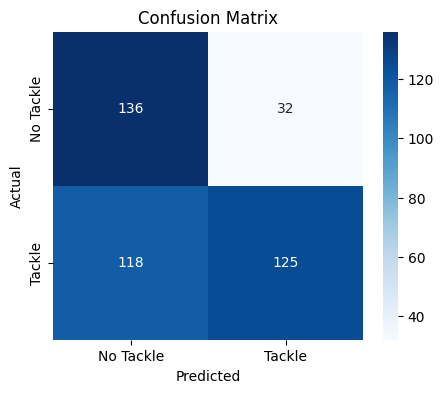

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.81      0.64       168
           1       0.80      0.51      0.62       243

    accuracy                           0.64       411
   macro avg       0.67      0.66      0.63       411
weighted avg       0.69      0.64      0.63       411



In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# =======================
# 5. TRAIN MODEL
# =======================
print("Training model...")
model = xgb.XGBClassifier(objective='binary:logistic', 
                          eval_metric='logloss',
                          n_estimators=100, 
                          max_depth=3, 
                          learning_rate=0.1,
                          scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # Balance classes
                          random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("Evaluating model...")

y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f"Validation F1-score: {f1:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Tackle', 'Tackle'], yticklabels=['No Tackle', 'Tackle'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))